# Inhaltsverzeichnis des Skripts:

[[_TOC_]]

---

### Vorliegende Datentyp:

**quantitative Daten auf Kardinalskala**

*Vorliegende Columns:*

- **Date:** Datum
- **Open:** Eröffnungskurs
- **High:** Höchstkurs
- **Low:** Tiefkurs
- **Close:** Schlusskurs
- **Volume:** Handelsvolumen

In [7]:
########################################################
#--------------- benötigten Librarys ------------------#
########################################################

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats

In [8]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


### Download und Speicherung der Datei

In [9]:
def download_stock_data(ticker_symbol, time_period, data_folder="../data"):
    """
    Lädt Aktiendaten von Yahoo Finance herunter und speichert sie als CSV.
    
    Args:
        ticker_symbol (str): Das Ticker-Symbol der Aktie (z.B. "MSFT" für Microsoft)
        time_period (str): Der Zeitraum für die Daten (z.B. "5y", "1mo", "max")
        data_folder (str): Pfad zum Datenordner, standardmäßig "../data" (eine Ebene hoch und dann in 'data')
    
    Returns:
        pandas.DataFrame: Der heruntergeladene Datensatz
        pandas.DataFrame: Statistische Zusammenfassung
    """
    
    # Erstelle Dateinamen aus dem Ticker-Symbol
    file_name = f"{ticker_symbol.lower()}_aktien_daten.csv"
    csv_file_location = os.path.join(data_folder, file_name)

    # Ticker-Objekt abrufen
    stock = yf.Ticker(ticker_symbol)
    
    # Historische Daten herunterladen
    hist_data = stock.history(period=time_period)

    # Entferne die Spalten 'Dividends' und 'Stock Splits'
    columns_to_drop = ['Dividends', 'Stock Splits']
    hist_data = hist_data.drop(columns=columns_to_drop, errors='ignore')
    
    # Daten als CSV speichern
    hist_data.to_csv(csv_file_location)
    print(f"Daten wurden in {csv_file_location} gespeichert.")

    # Erste Spalte zu Datum konvertieren und als Index setzen
    hist_data = hist_data.reset_index()
    hist_data['Date'] = pd.to_datetime(hist_data['Date']).dt.normalize()  # Entfernt die Uhrzeit
    hist_data = hist_data.set_index('Date')
    hist_data.to_csv(csv_file_location, date_format='%Y-%m-%d')

    # Konvertiere alle numerischen Spalten zu Float
    for col in hist_data.columns:
        hist_data[col] = pd.to_numeric(hist_data[col], errors='coerce')

    # Allgemeine Infos
    print(f"+{'-'*48}+")
    print(f"|{'Allgemeine Informationen der Aktien-Daten':^48}|")
    print(f"+{'-'*48}+ \n")
    hist_data.info()
    
    # Statistische Zusammenfassung
    data_zusammenfassung = hist_data.describe()
    print(f"\n\n")
    print(f"+{'-'*48}+")
    print(f"|{'Statistische Zusammenfassung der Aktien-Daten':^48}|")
    print(f"+{'-'*48}+ \n")
    print(data_zusammenfassung)

    return hist_data, data_zusammenfassung, csv_file_location

## Erste Analyse des Datensatzes

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_stock_data(file_path):
    """
    Führt eine umfassende Analyse eines Aktiendatensatzes aus einer CSV-Datei durch.
    
    Args:
        file_path (str): Pfad zur CSV-Datei mit den Aktiendaten
        
    Returns:
        dict: Ein Dictionary mit verschiedenen Analyseergebnissen
    """
    # Überprüfe, ob die Datei existiert
    if not os.path.exists(file_path):
        print(f"FEHLER: Die Datei {file_path} existiert nicht.")
        return None
    
    # Lade die Daten
    try:
        # Versuche, die Daten zu laden und das Datum als Index zu setzen
        df = pd.read_csv(file_path)
        
        # Prüfe, ob 'Date' oder ein ähnliches Datumsfeld vorhanden ist
        date_columns = [col for col in df.columns if 'date' in col.lower() or 'datum' in col.lower()]
        
        if date_columns:
            # Verwende die erste gefundene Datumsspalte
            date_col = date_columns[0]
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            df = df.set_index(date_col)
        elif 'Unnamed: 0' in df.columns:
            # Typischer Fall bei aus yfinance exportierten CSV-Dateien
            df['Date'] = pd.to_datetime(df['Unnamed: 0'], errors='coerce')
            df = df.drop(columns=['Unnamed: 0'])
            df = df.set_index('Date')
    
    except Exception as e:
        print(f"FEHLER beim Laden der Datei: {e}")
        return None
    
    # Ausgabe des Dateinamens und grundlegende Informationen
    file_name = os.path.basename(file_path)
    print(f"\n{'='*50}")
    print(f"ANALYSE DER DATEI: {file_name}")
    print(f"{'='*50}")
    
    # 1. Grundlegende Informationen
    print("\n1. GRUNDLEGENDE INFORMATIONEN")
    print(f"{'='*50}")
    print(f"Zeitraum: {df.index.min()} bis {df.index.max()}")
    print(f"Anzahl der Datenpunkte: {len(df)}")
    print(f"Anzahl der Variablen: {df.shape[1]}")
    
    # Speichere die Analyse-Ergebnisse
    results = {
        'file_name': file_name,
        'data_points': len(df),
        'variables': df.shape[1],
        'period': {
            'start': df.index.min(),
            'end': df.index.max(),
            'days': (df.index.max() - df.index.min()).days
        }
    }
    
    # 2. Datentypanalyse
    print("\n2. DATENTYPEN")
    print(f"{'='*50}")
    dtypes = df.dtypes
    print(dtypes)
    
    results['data_types'] = {col: str(dtype) for col, dtype in dtypes.items()}
    
    # 3. Fehlende Werte-Analyse
    print("\n3. FEHLENDE WERTE")
    print(f"{'='*50}")
    
    # Anzahl und Prozentsatz der fehlenden Werte
    na_count = df.isna().sum()
    na_percent = 100 * na_count / len(df)
    
    # Kombiniere die Ergebnisse
    na_summary = pd.DataFrame({
        'Fehlende Werte': na_count,
        'Prozent fehlend': na_percent
    })
    
    print(na_summary)
    
    # Gesamtanzahl der fehlenden Werte
    total_missing = na_count.sum()
    total_missing_percent = 100 * total_missing / (len(df) * df.shape[1])
    
    print(f"\nGesamtanzahl fehlender Werte: {total_missing} ({total_missing_percent:.2f}%)")
    
    results['missing_values'] = {
        'per_column': {col: {'count': int(count), 'percent': float(percent)} 
                      for col, count, percent in zip(na_summary.index, na_count, na_percent)},
        'total': {
            'count': int(total_missing),
            'percent': float(total_missing_percent)
        }
    }
    
    # 4. Deskriptive Statistik
    print("\n4. DESKRIPTIVE STATISTIK")
    print(f"{'='*50}")
    
    # Sinnvolle Statistiken für numerische Daten
    desc_stats = df.describe().T
    
    # Füge zusätzliche Statistiken hinzu
    desc_stats['Var'] = df.var()
    desc_stats['Skewness'] = df.skew()
    desc_stats['Kurtosis'] = df.kurtosis()
    
    print(desc_stats)
    
    results['descriptive_stats'] = desc_stats.to_dict()
    
    # 5. Untersuchung auf Ausreißer
    print("\n5. AUSREISSERANALYSE")
    print(f"{'='*50}")
    
    # Z-Score-Methode zur Identifizierung von Ausreißern
    outliers = {}
    
    for col in df.select_dtypes(include=np.number).columns:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outliers_count = (z_scores > 3).sum()  # Werte, die mehr als 3 Standardabweichungen vom Mittelwert entfernt sind
        outliers_percent = 100 * outliers_count / len(z_scores)
        
        outliers[col] = {
            'count': int(outliers_count),
            'percent': float(outliers_percent)
        }
        
        print(f"Spalte '{col}': {outliers_count} Ausreißer ({outliers_percent:.2f}%)")
    
    results['outliers'] = outliers
    
    # 6. Korrelationsanalyse
    print("\n6. KORRELATIONSANALYSE")
    print(f"{'='*50}")
    
    try:
        corr = df.corr(method='pearson')
        print(corr)
        
        # Visualisiere die Korrelationsmatrix (optional)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Korrelationsmatrix der Aktienparameter')
        plt.tight_layout()
        plt.show()
        
        results['correlation'] = corr.to_dict()
    except Exception as e:
        print(f"Konnte keine Korrelationsanalyse durchführen: {e}")
        results['correlation'] = None
    
    # 7. Renditeberechnung (spezifisch für Aktiendaten)
    print("\n7. RENDITEANALYSE")
    print(f"{'='*50}")
    
    if 'Close' in df.columns:
        # Tägliche Renditen
        df['Daily_Return'] = df['Close'].pct_change()
        
        # Logarithmische Renditen
        df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
        
        # Statistiken der Renditen
        returns_stats = df[['Daily_Return', 'Log_Return']].describe()
        print("Renditestatistiken:")
        print(returns_stats)
        
        # Annualisierte Rendite und Volatilität
        # Annahme: 252 Handelstage pro Jahr
        annual_return = df['Daily_Return'].mean() * 252
        annual_volatility = df['Daily_Return'].std() * np.sqrt(252)
        
        print(f"\nAnnualisierte Rendite: {annual_return:.4f} ({annual_return*100:.2f}%)")
        print(f"Annualisierte Volatilität: {annual_volatility:.4f} ({annual_volatility*100:.2f}%)")
        
        # Sharpe Ratio (Annahme: risikofreier Zinssatz von 0%)
        sharpe_ratio = annual_return / annual_volatility
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        
        results['returns'] = {
            'stats': returns_stats.to_dict(),
            'annual_return': float(annual_return),
            'annual_volatility': float(annual_volatility),
            'sharpe_ratio': float(sharpe_ratio)
        }
    else:
        print("Keine 'Close'-Spalte für die Renditeberechnung gefunden.")
        results['returns'] = None
    
    # 8. Zusammenfassung der wichtigsten Erkenntnisse
    print("\n8. ZUSAMMENFASSUNG")
    print(f"{'='*50}")
    
    print(f"- Der Datensatz umfasst {len(df)} Datenpunkte über {(df.index.max() - df.index.min()).days} Tage.")
    print(f"- Es gibt {total_missing} fehlende Werte ({total_missing_percent:.2f}% der Gesamtdaten).")
    
    if 'Close' in df.columns:
        print(f"- Die Aktie hat eine annualisierte Rendite von {annual_return*100:.2f}% bei einer Volatilität von {annual_volatility*100:.2f}%.")
        print(f"- Die Sharpe Ratio beträgt {sharpe_ratio:.4f}.")
    
    # Identifiziere hochkorrelierte Spalten
    if results['correlation'] is not None:
        high_corr_pairs = []
        
        for i in range(len(corr.columns)):
            for j in range(i+1, len(corr.columns)):
                if abs(corr.iloc[i, j]) > 0.8:  # Hohe Korrelation
                    high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
        
        if high_corr_pairs:
            print("\nHoch korrelierte Variablen:")
            for var1, var2, corr_val in high_corr_pairs:
                print(f"- {var1} und {var2}: {corr_val:.4f}")
    
    return results

### Ausführung der Download Funktion

In [11]:
# Verwendung der Funktion
if __name__ == "__main__":
    # Aktien Daten herunterladen
    data = download_stock_data("MSFT", "max")
    data = download_stock_data("005930.KS", "max")
    data = download_stock_data("MBG.DE", "max")

Daten wurden in ../data\msft_aktien_daten.csv gespeichert.
+------------------------------------------------+
|   Allgemeine Informationen der Aktien-Daten    |
+------------------------------------------------+ 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9872 entries, 1986-03-13 00:00:00-05:00 to 2025-05-16 00:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9872 non-null   float64
 1   High    9872 non-null   float64
 2   Low     9872 non-null   float64
 3   Close   9872 non-null   float64
 4   Volume  9872 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 462.8 KB



+------------------------------------------------+
| Statistische Zusammenfassung der Aktien-Daten  |
+------------------------------------------------+ 

              Open         High          Low        Close        Volume
count  9872.000000  9872.000000  9872.000000  9872.000000  9.872000e+03
mean     59.699744 

### Ausführen der Analyse Funktion


ANALYSE DER DATEI: msft_aktien_daten.csv

1. GRUNDLEGENDE INFORMATIONEN
Zeitraum: 1986-03-13 00:00:00 bis 2025-05-16 00:00:00
Anzahl der Datenpunkte: 9872
Anzahl der Variablen: 5

2. DATENTYPEN
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

3. FEHLENDE WERTE
        Fehlende Werte  Prozent fehlend
Open                 0              0.0
High                 0              0.0
Low                  0              0.0
Close                0              0.0
Volume               0              0.0

Gesamtanzahl fehlender Werte: 0 (0.00%)

4. DESKRIPTIVE STATISTIK
         count          mean           std           min           25%  \
Open    9872.0  5.969974e+01  1.021689e+02  5.427671e-02  3.678032e+00   
High    9872.0  6.029820e+01  1.031219e+02  5.640509e-02  3.725924e+00   
Low     9872.0  5.908517e+01  1.011720e+02  5.427671e-02  3.630140e+00   
Close   9872.0  5.971794e+01  1.022018e+02  5.534090e-02  3.676837e+00   
Volum

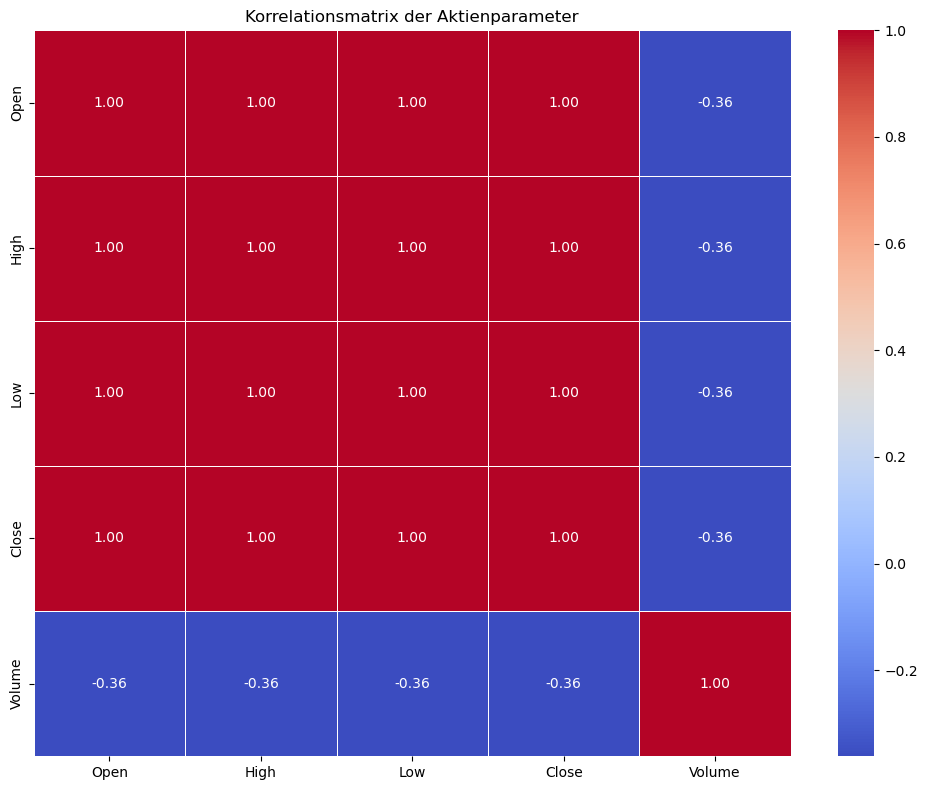


7. RENDITEANALYSE
Renditestatistiken:
       Daily_Return   Log_Return
count   9871.000000  9871.000000
mean       0.001128     0.000906
std        0.021028     0.021089
min       -0.301159    -0.358332
25%       -0.009112    -0.009154
50%        0.000380     0.000380
75%        0.011188     0.011126
max        0.195652     0.178692

Annualisierte Rendite: 0.2842 (28.42%)
Annualisierte Volatilität: 0.3338 (33.38%)
Sharpe Ratio: 0.8514

8. ZUSAMMENFASSUNG
- Der Datensatz umfasst 9872 Datenpunkte über 14309 Tage.
- Es gibt 0 fehlende Werte (0.00% der Gesamtdaten).
- Die Aktie hat eine annualisierte Rendite von 28.42% bei einer Volatilität von 33.38%.
- Die Sharpe Ratio beträgt 0.8514.

Hoch korrelierte Variablen:
- Open und High: 0.9999
- Open und Low: 0.9999
- Open und Close: 0.9999
- High und Low: 0.9999
- High und Close: 0.9999
- Low und Close: 0.9999

Analyse abgeschlossen!


In [12]:

# Beispiel für die Verwendung
if __name__ == "__main__":
    # Passe den Pfad zur tatsächlichen CSV-Datei an
    file_path = "../data/msft_aktien_daten.csv"
    analysis_results = analyze_stock_data(file_path)
    
    # Die Ergebnisse sind als Dictionary verfügbar und können weiterverarbeitet werden
    if analysis_results:
        print("\nAnalyse abgeschlossen!")